In [24]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, PolynomialFeatures
from sklearn import svm
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, roc_auc_score, recall_score, accuracy_score, classification_report, r2_score as r2
from sklearn.model_selection import KFold, RepeatedKFold, GridSearchCV, train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge
from pytorch_tabnet.tab_model import TabNetRegressor
from xgboost import XGBClassifier
import torch
import keras
from scikeras.wrappers import KerasClassifier
import tensorflow as tf
from keras.models import Sequential
from keras import layers
from sklearn.pipeline import make_pipeline
from scikeras.wrappers import KerasClassifier
from sklearn.ensemble import StackingClassifier, StackingRegressor
from sklearn.neural_network import MLPClassifier
from tqdm import tqdm
import time

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
matplotlib.rcParams['figure.figsize'] = (11.0, 8.0)

In [25]:
#Importing Data
df = pd.read_csv('../Data/address_data_combined.csv')
X = df.drop(columns=['Address', 'FLAG'])
y = df['FLAG']
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)


columns = ['Avg min between sent tnx', 'Avg min between received tnx',
       'Time Diff between first and last (Mins)',
       'Unique Received From Addresses', 'min value received',
       'max value received ', 'avg val received', 'min val sent',
       'avg val sent', 'total transactions (including tnx to create contract',
       'total ether received', 'total ether balance']
    
scaler = MinMaxScaler()

# Log for Skewed Data
for c in columns:
    X_train_full[c] = X_train_full[c].apply(lambda x: np.log(x) if x > 0 else 0)
    X_test[c] = X_test[c].apply(lambda x: np.log(x) if x > 0 else 0)

# Scaling
X_train_full = scaler.fit_transform(X_train_full)
X_test = scaler.transform(X_test)

np.isnan(X_train_full)

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [32]:
default_params = {'gamma': 1.2, 'lambda_sparse': 0.0001, 'momentum': 0.3, 'optimizer_params': {'lr': 0.02}, 'verbose': 0}

tabnet = TabNetClassifier(
                **default_params
)

def evaluate_model(model, X, y):
    cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
    scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
    return scores

# define dataset
X, y = X_train_full, y_train_full

scores = evaluate_model(tabnet, X, y)

print('>%s %.3f (%.3f)' % ('Tabnet', np.mean(scores), np.std(scores)))
# plot model performance for comparison

>Tabnet 0.928 (0.011)


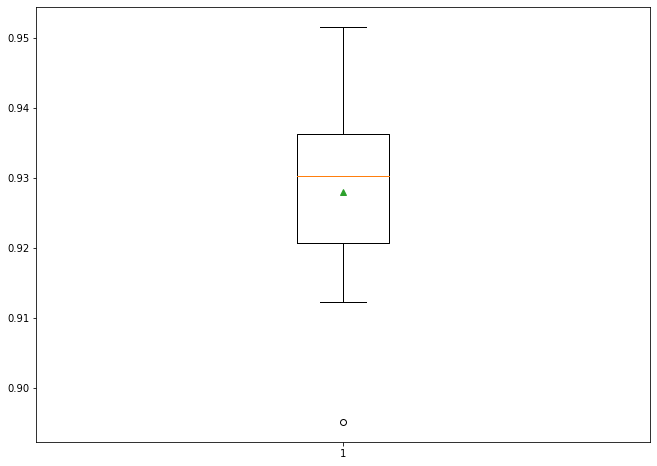

In [33]:
# plot model performance for comparison
plt.boxplot(scores,showmeans=True)
plt.show()

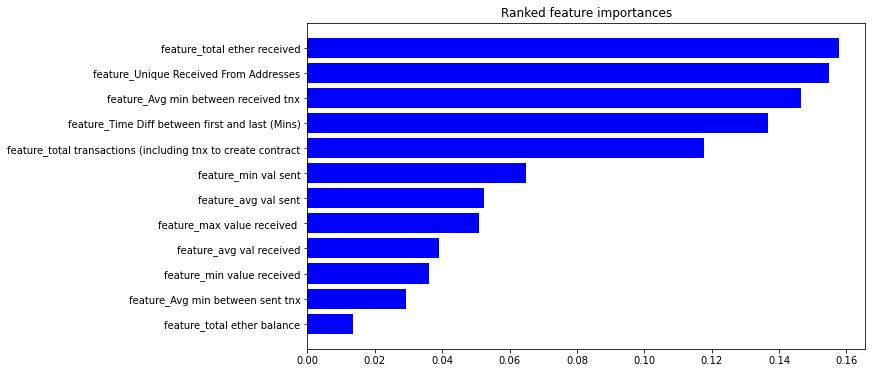

In [49]:
tabnet.fit(X_train_full, y_train_full)
feat_importances = tabnet.feature_importances_
indices = np.argsort(feat_importances)
# plot
fig, ax = plt.subplots(figsize=(10, 6))
plt.title("Ranked feature importances")
plt.barh(range(len(feat_importances)), feat_importances[indices],color="b", align="center")
features = ['feature_{}'.format(columns[i]) for i in range(len(columns))]
plt.yticks(range(len(feat_importances)), [features[idx] for idx in indices])
plt.ylim([-1, len(feat_importances)])
plt.show();

In [52]:
y_predicted = tabnet.predict(X_test)

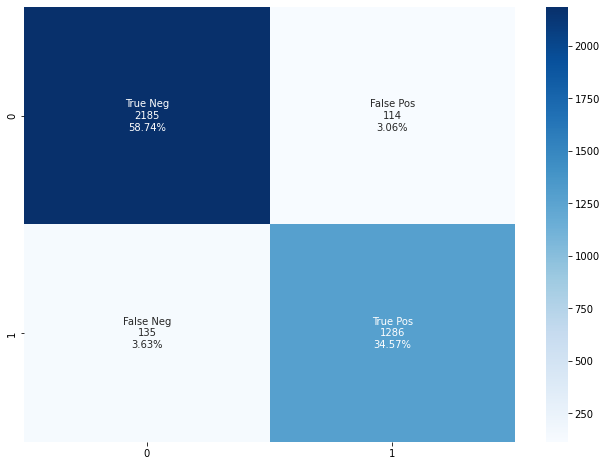

Test Validation - Accuracy: 0.9330645161290323 Recall: 0.9049964813511612


In [54]:
cf_matrix = confusion_matrix(y_test, y_predicted)
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in
                cf_matrix.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')
plt.show()
print('Test Validation - Accuracy:', accuracy_score(y_test, y_predicted), 'Recall:', recall_score(y_test, y_predicted))